# **<p style = "text-align: center">LẬP TRÌNH KHOA HỌC DỮ LIỆU</p>**
## **<p style = "text-align: center">Đồ án Cuối kì</p>**
## **<p style = "text-align: center">KHÁM PHÁ VÀ TIỀN XỬ LÝ DỮ LIỆU</p>**
### <p style = "text-align: center"> <b>Đề tài:</b> KHÁM PHÁ, THỐNG KÊ CỦA TOP CÁC CA KHÚC TRÊN SPOTIFY</p>
<p style = "text-align: center"> Sinh viên thực hiện </p>

| Mã số sinh viên | Họ và tên |
| --- | --- |
| 20120040 | Nguyễn Quang Gia Bảo |
| 20120136 | Huỳnh Tuấn Nam |
| 20120158 | Trần Hoàng Anh Phi |

---

# **1. Import các packages cần thiết**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer

from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, cross_validate, KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error

pd.set_option('display.max_columns', None)
import warnings 
warnings.filterwarnings("ignore")

# **2. Đọc dữ liệu từ file csv**

In [2]:
house_df = pd.read_csv('csv/EDA_Preprocessing.csv', index_col=False)

In [3]:
house_df.head(5)

,Date,Address,District,Ward,Type,Legal,Number of floors,Number of bedrooms,Area,Length,Width,Price/m2,Unit
0,2020-08-05,"Đường Hoàng Quốc Việt, Phường Nghĩa Đô, Quận C...",Quận Cầu Giấy,Phường Nghĩa Đô,"Nhà ngõ, hẻm",Đã có sổ,4.0,5.0,46.0,NaN,NaN,86960000.0,triệu/m²
1,2020-08-05,"Đường Kim Giang, Phường Kim Giang, Quận Thanh ...",Quận Thanh Xuân,Phường Kim Giang,"Nhà mặt phố, mặt tiền",NaN,NaN,3.0,37.0,NaN,NaN,116220000.0,triệu/m²
2,2020-08-05,"phố minh khai, Phường Minh Khai, Quận Hai Bà T...",Quận Hai Bà Trưng,Phường Minh Khai,"Nhà ngõ, hẻm",Đã có sổ,4.0,4.0,40.0,10.00,4.0,65000000.0,triệu/m²
3,2020-08-05,"Đường Võng Thị, Phường Thụy Khuê, Quận Tây Hồ,...",Quận Tây Hồ,Phường Thụy Khuê,"Nhà ngõ, hẻm",Đã có sổ,NaN,6.0,51.0,12.75,4.0,100000000.0,triệu/m²
4,2020-08-05,"Đường Kim Giang, Phường Kim Giang, Quận Thanh ...",Quận Thanh Xuân,Phường Kim Giang,"Nhà ngõ, hẻm",NaN,NaN,4.0,36.0,9.00,4.0,86110000.0,triệu/m²


In [4]:
house_df.shape

(81681, 13)

# **3. Xác định câu hỏi cần trả lời:**
**Bài toán dự đoán `Price/m2` dựa trên các đặc trưng của ngôi nhà.**
- Đây là một bài toán hồi quy.
- Input là các đặc trưng ảnh hưởng đến giá bán của một ngôi nhà.
- Output là giá của một ngôi nhà (m2). 

# **4. Phân tích, xử lý và chuẩn bị dữ liệu cho bước mô hình hoá**

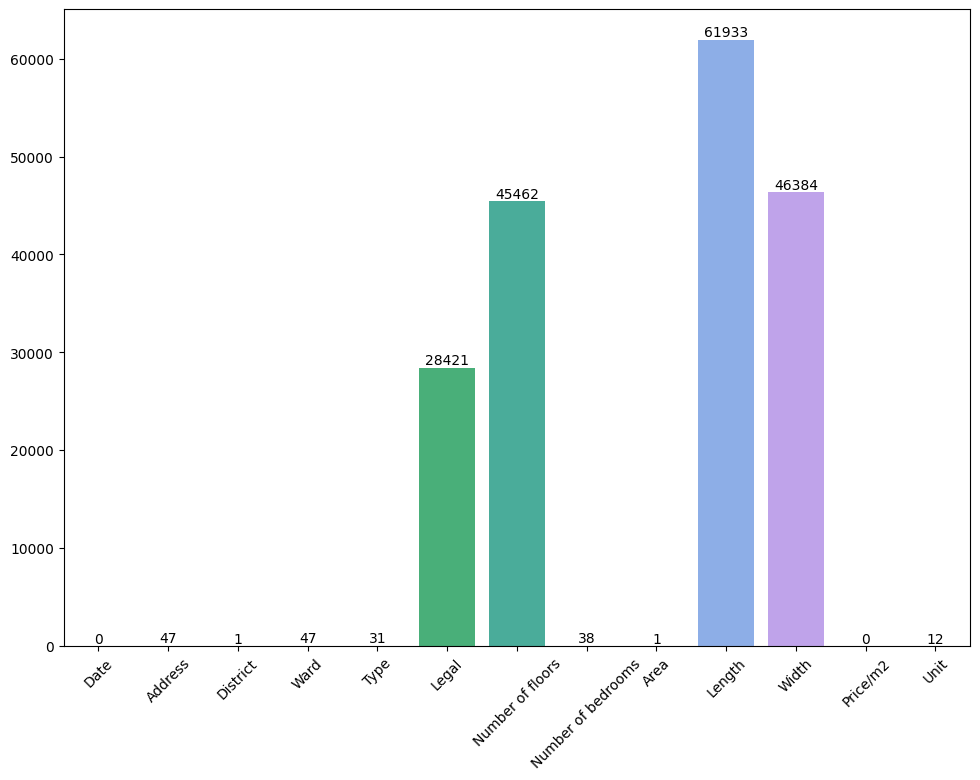

In [5]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
missing_df = house_df.isna().sum()
sns.barplot(y = missing_df, x = missing_df.index, ax = ax)
ax.tick_params(axis = 'x', rotation = 45)
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

Drop các hàng có giá trị nan quá nhiều (hơn 50% dữ liệu)

In [6]:
# house_df.dropna(inplace=True)
house_df = house_df[house_df['Length'].notna() & house_df['Width'].notna() & house_df['Number of floors'].notna()]
house_df.reset_index(inplace=True, drop=True)

In [7]:
house_df.shape

(11532, 13)

In [8]:
house_df.Legal.value_counts()

Đã có sổ        11271
Đang chờ sổ        93
Giấy tờ khác       75
Name: Legal, dtype: int64

In [9]:
# # house_df['Address'].str.split(', ').apply(lambda x: x[len(x)] if type(x)==list else x).value_counts()
# house_df["Address"][np.invert(house_df["Address"].str.contains('Đường'))]
# # Các địa chỉ không chứa Đường
# non_street = np.invert(house_df["Address"].str.contains('Đường')) 
# # Split địa chỉ từ chữ phường và lấy index trước chữ đó
# idx = house_df['Address'][non_street].str.split(', Phường').apply(lambda x: len(x[0].split(', '))) 
# print(idx.value_counts())
# # Với các idx = 1 thì không cần xử lý nữa
# print(house_df.iloc[idx[idx==6].index]['Address'])
# print(house_df.iloc[idx[idx==3].index]['Address'].apply(lambda x: x.split(', ')))

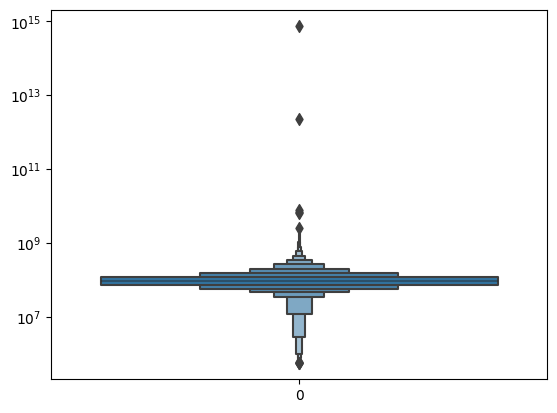

In [10]:
fig, ax = plt.subplots()
sns.boxenplot(data =house_df['Price/m2'], ax=ax)
ax.set_yscale('log')

#### **Xử lý các giá trị ngoại lệ**:
- Tính phân vị thứ nhất và phân vị thứ 3 -> IQR.
- $Lower Bound = Q1 - 1.5*IQR$ 
- $Upper Bound = Q3 + 1.5*IQR$
- Với các giá trị nhỏ hơn $Lower Bound$ hoặc lớn hơn $Upper Bound$ thì được xác định là outliers và được chuyển thành giá trị min (max) gần với nó.

Index(['Number of floors', 'Number of bedrooms', 'Area', 'Length', 'Width',
       'Price/m2'],
      dtype='object')


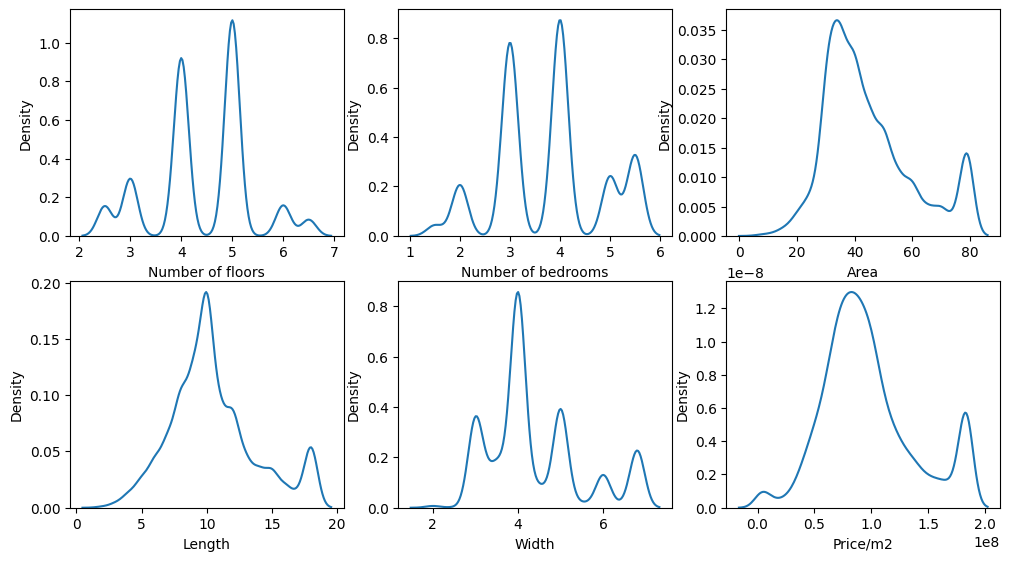

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
class BoxplotOutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, whisker_coeff: float = 1.5):
        self.whisker = whisker_coeff
        self.lower = None
        self.upper = None

    def fit(self, col: pd.Series):
        Q1 = col.quantile(0.25)
        Q3 = col.quantile(0.75)
        IQR = Q3 - Q1
        self.lower = Q1 - self.whisker * IQR
        self.upper = Q3 + self.whisker * IQR
        return self

    def transform(self, X):
        return X.clip(self.lower, self.upper)

cols = house_df.select_dtypes(np.number).columns
print(cols)
cols_ = list(filter(lambda x: x!='Price/m2', cols))
fig = plt.figure(figsize=(12, 10))
for i, col in enumerate(cols, 1):
    ax = plt.subplot(3,3, i)
    house_df[col] = BoxplotOutlierClipper().fit_transform(house_df[col])
    sns.kdeplot(house_df[col])
# fig, ax = plt.subplots(4,1)
# sns.catplot(data =house_df[cols_], kind='violin')


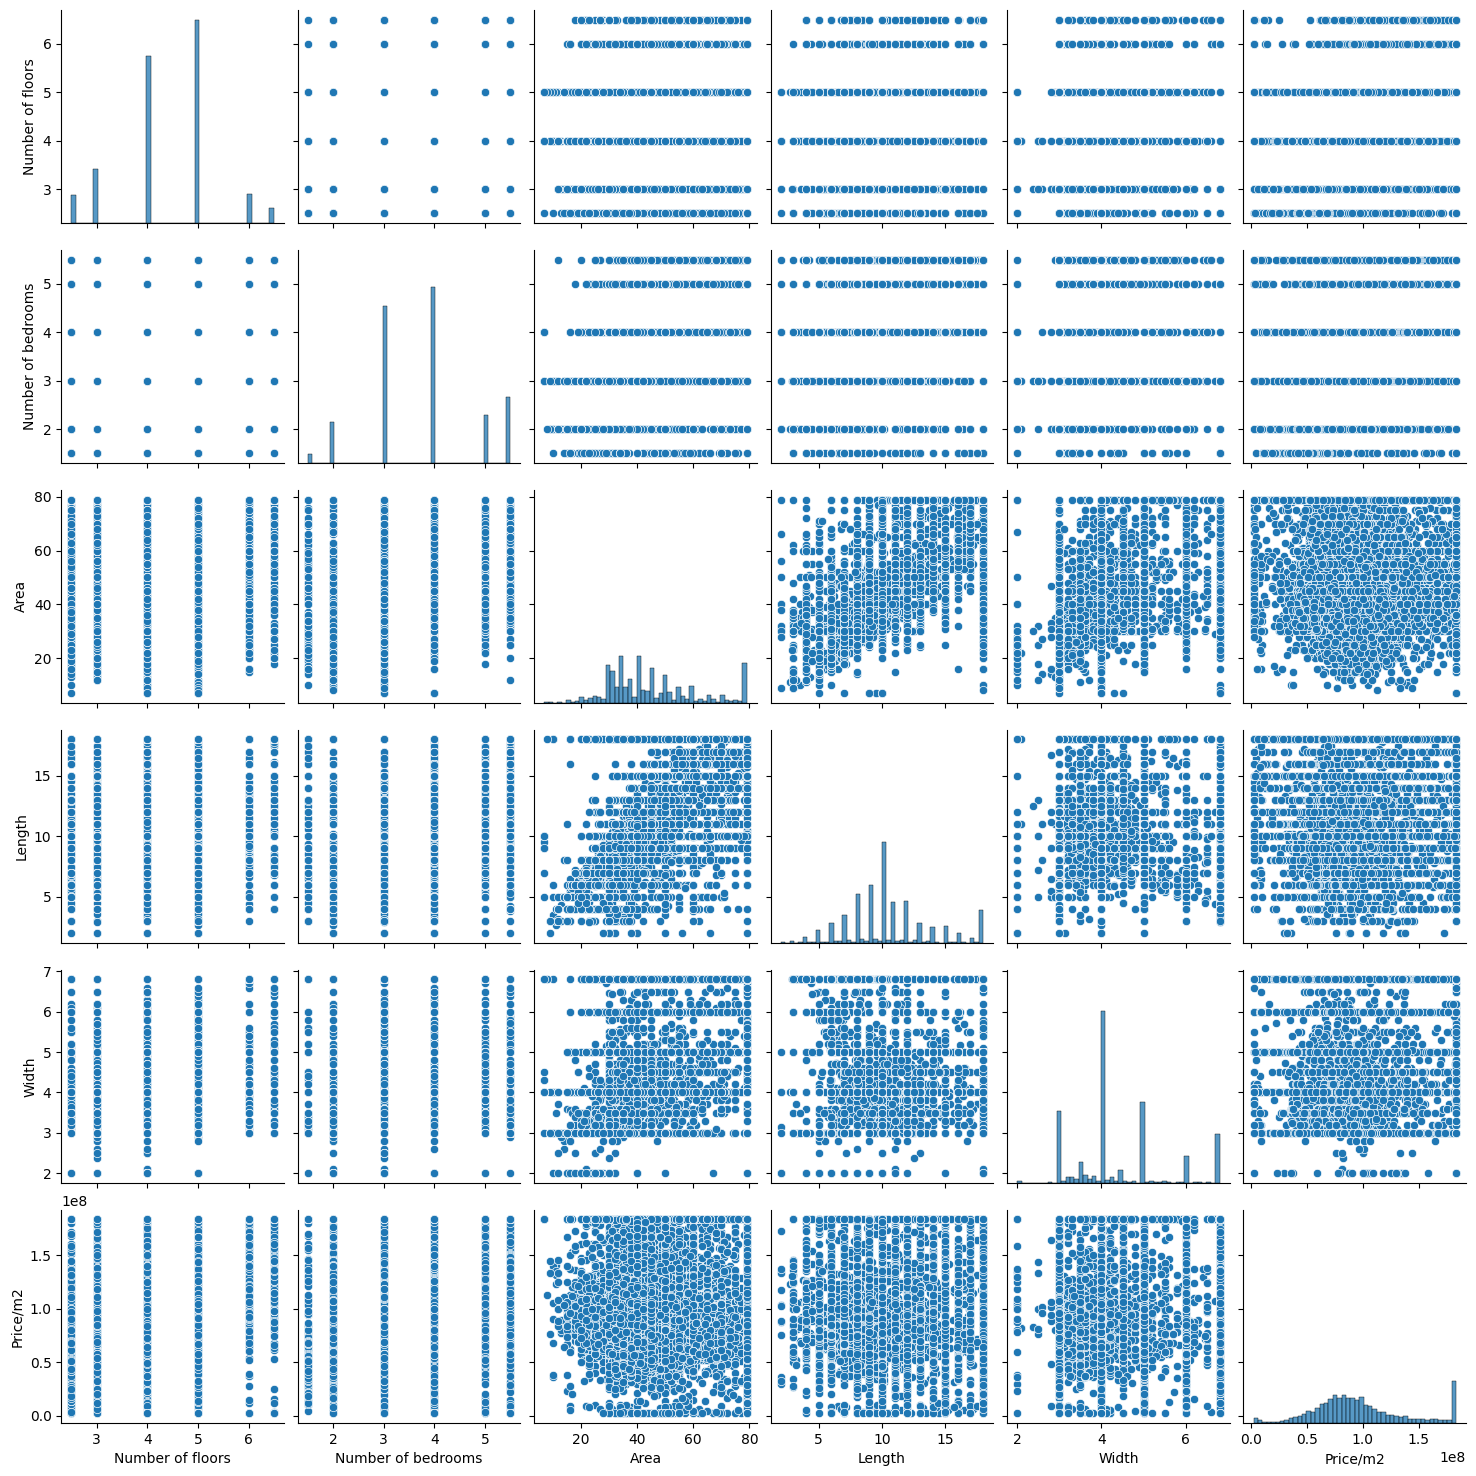

In [12]:
sns.pairplot(house_df.select_dtypes(include=np.number), kind='scatter')

In [ ]:
house_df.isna().sum()

Date                   0
Address                0
District               0
Ward                   2
Type                   0
Legal                 93
Number of floors       0
Number of bedrooms     0
Area                   0
Length                 0
Width                  0
Price/m2               0
Unit                   2
dtype: int64

#### **Phân chia tập train/val/test và scale dữ liệu**

In [211]:
cols = ['District', 'Ward','Type', 'Legal', 'Number of floors', 'Number of bedrooms', 'Area', 'Length', 'Width',
       'Price/m2']
x_df = house_df[set(cols) - {'Price/m2'}]
y_df = house_df['Price/m2']

def get_dataset(x_df, y_df, input_scaler, output_scaler):
    x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=5)
    if input_scaler is not None:
        input_scaler.fit(x_train)
        x_train = input_scaler.transform(x_train)
        x_test = input_scaler.transform(x_test)
    if output_scaler is not None:
        y_train = y_train.values.reshape(len(y_train), 1)
        y_test = y_test.values.reshape(len(y_test), 1)
        output_scaler.fit(y_train)
        y_train = output_scaler.transform(y_train)
        y_test = output_scaler.transform(y_test)
    return x_train, x_test, y_train, y_test    

In [206]:
x_df.columns

Index(['Width', 'Type', 'Legal', 'Length', 'Number of floors', 'District',
       'Ward', 'Area', 'Number of bedrooms'],
      dtype='object')

#### **Pipeline cho bước tiền xử lý**

In [212]:
# cate = ['Type', 'Legal', 'District', 'Ward'] [1, 2, 5, 6]
# nume = ['Width', 'Length', Number of floors','Area', 'Number of bedrooms'] [0, 3, 4, 7, 8]

# Scale cho giá trị output bằng hàm log
target_transfomer = FunctionTransformer(np.log, inverse_func = np.exp, validate=True ,check_inverse = True)

# Pipeline xử lý cho các cột category
# Thay thế missing value bằng giá trị có tần suất xuất hiện cao
cate_transformer = Pipeline(steps= [('imputer', SimpleImputer(strategy='most_frequent')), 
                               ('OneHotEncoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))]) # biểu diễn one hot cho các cột category
                                            # đối với các giá trị mà model chưa từng thấy bao giờ (trong tập test) thì ta bỏ qua
# Scale các cột numeric bằng Standard Scale
nume_transfomer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[('cate_transformer', cate_transformer, [1, 2, 5, 6]),
                                                ('nume_transfomer',nume_transfomer, [0, 3, 4, 7, 8])])

# **5. Huấn luyện mô hình**

### **RandomForest Regression**

Transform output bằng hàm log

In [370]:
x_train, x_test, y_train, y_test = get_dataset(x_df, y_df, preprocessor, target_transfomer)

In [371]:
model = RandomForestRegressor()
lr_pl = Pipeline(steps=[('preprocessor', preprocessor),
                                ('rf_regression', model)])

lr_pl.fit(x_train, y_train)
y_train_pred = lr_pl.predict(x_train)

Scale về lại giá trị ban đầu

In [372]:
y_test_pred = lr_pl.predict(x_test)
# # Scale to original
def inverse_scale(col, transfomer):
    col = transfomer.inverse_transform(col.reshape(-1, 1)).reshape(-1)
    return col

y_train =  inverse_scale(y_train, target_transfomer)
y_train_pred =  inverse_scale(y_train_pred, target_transfomer)

y_test =  inverse_scale(y_test, target_transfomer)
y_test_pred =  inverse_scale(y_test_pred, target_transfomer)

So sánh giá trị **actual** và **predict** trên tập test

In [373]:
result = pd.DataFrame({'Actual': y_test, 'Predict': y_test_pred})
pd.set_option('display.float_format', lambda x: '%.3f' % x)
result.head(5)

,Actual,Predict
0,121210000.000,107846575.212
1,96490000.000,80719245.528
2,103000000.000,80719245.528
3,183435000.000,97615985.135
4,90700000.000,80719245.528


In [250]:
print(f'Train set: [MAE: {mean_absolute_error(y_train, y_train_pred):.3f}, MAPE: {100-mean_absolute_percentage_error(y_train, y_train_pred):.3f}]')
print(f'Test set: [MAE: {mean_absolute_error(y_test, y_test_pred):.3f}, MAPE: {100-mean_absolute_percentage_error(y_test, y_test_pred):.3f}]')

Train set: [MAE: 29289810.842, MAPE: 99.298]
Test set: [MAE: 28874672.070, MAPE: 99.388]


### **MLP (Multilayer Perceptron)** 

**Scale dữ liệu đầu vào theo pipeline Preprocessor và dữ liệu đầu ra bằng Standard scale** 

In [379]:
std = StandardScaler()
x_train, x_test, y_train, y_test = get_dataset(x_df, y_df, preprocessor, std)

In [252]:
x_train.shape, x_test.shape

((9225, 266), (2307, 266))

In [279]:
y_train.shape, y_test.shape

((9225, 1), (2307, 1))

Sử dụng mô hình MLP với đầu vào 266 features, 1 lớp ẩn với 10 nodes và dùng hàm kích hoạt 'relu', hàm tối ưu là Stochastic Gradient (learning rate = 0.01, momentum = 0.9).

Chia tập validation = 0.2 

train_mse: 0.447, val_mse: 0.560
289/289 [==============================] - 0s 549us/step


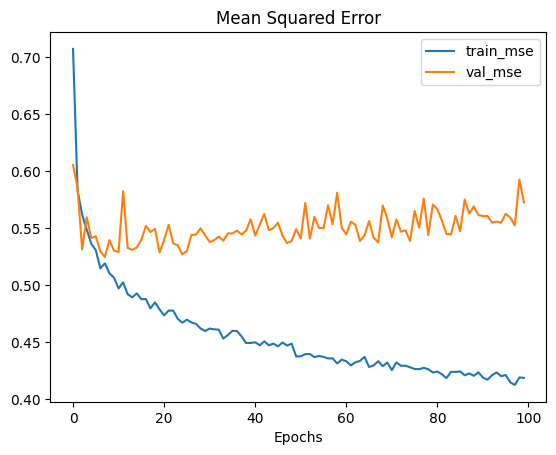

In [382]:
model = Sequential()

model.add(Dense(units=10, input_dim=x_train.shape[1], activation='relu', kernel_initializer='normal'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer=SGD(lr=0.01, momentum=0.9))
history = model.fit(x_train, y_train, epochs=100, verbose=0, validation_split=0.2)

train_mse = model.evaluate(x_train, y_train, verbose=0)
test_mse = model.evaluate(x_test, y_test, verbose=0)
print(f'train_mse: {train_mse:.3f}, val_mse: {test_mse:.3f}')

y_train_pred = model.predict(x_train)

plt.title('Mean Squared Error')
plt.plot(history.history['loss'], label='train_mse')
plt.plot(history.history['val_loss'], label='val_mse')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [383]:
y_test_pred = model.predict(x_test)

y_train =  inverse_scale(y_train, std)
y_train_pred =  inverse_scale(y_train_pred, std)

y_test =  inverse_scale(y_test, std)
y_test_pred =  inverse_scale(y_test_pred, std)

73/73 [==============================] - 0s 750us/step


So sánh giá trị **actual** và **predict** trên tập test

In [384]:
compare = pd.DataFrame({'Actual': y_train, 'Predict': y_train_pred}).apply(lambda x: x/1e6)
compare.sample(5)

,Actual,Predict
6121,88.240,87.426
4994,88.890,102.161
3777,89.530,83.004
6771,114.710,108.560
8218,80.950,110.117


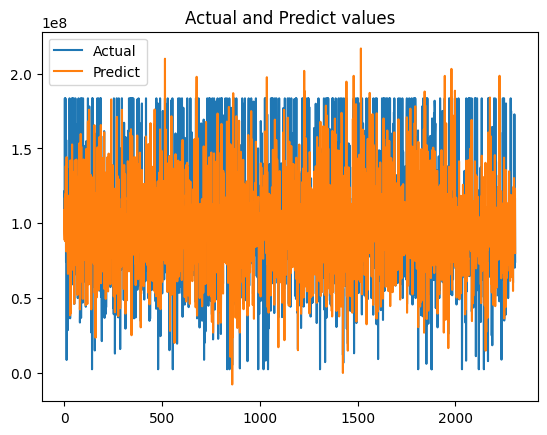

In [315]:
plt.plot(y_test)
plt.plot(y_test_pred)
plt.legend(['Actual', 'Predict'])
plt.title('Actual and Predict values')
plt.show()

In [316]:
print(f'Train set: [MAE: {mean_absolute_error(y_train, y_train_pred):.3f},\
      MAPE: {100-mean_absolute_percentage_error(y_train, y_train_pred):.3f}]')
print(f'Test set: [MAE: {mean_absolute_error(y_test, y_test_pred):.3f},\
      MAPE: {100-mean_absolute_percentage_error(y_test, y_test_pred):.3f}]')

Train set: [MAE: 19369753.190,      MAPE: 99.444]
Test set: [MAE: 21617992.059,      MAPE: 99.462]


## **Fine-tuning process**

Sử dụng kĩ thuật RandomizedSearchCV()

Phương pháp này tìm kiếm ngẫu nhiên trên không gian tham số, kết hợp với Cross-validation và chọn ra bộ tham số tốt nhất cho mô hình. 

#### **Fine-tune cho Keras Regression**

In [374]:
std = StandardScaler()
x_train, x_test, y_train, y_test = get_dataset(x_df, y_df, preprocessor, std)

In [319]:
params = {'batch_size':[10, 20, 30, 50, 80],
             'epochs':[10, 20, 50, 80, 100],
             'optimizer':['adam', 'rmsprop', 'sgd', 'lbfgs']}

def build_model(optimizer):
    model = Sequential()
    model.add(Dense(units=10, input_dim=x_train.shape[1], activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

ANN = KerasRegressor(build_model, verbose=0)
ANN_random = RandomizedSearchCV(estimator = ANN, param_distributions = params, 
                               scoring='neg_mean_squared_error', cv = 5, verbose=0, random_state=10)



ANN_random.fit(x_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x00000191D2727760>,
                   param_distributions={'batch_size': [10, 20, 30, 50, 80],
                                        'epochs': [10, 20, 50, 80, 100],
                                        'optimizer': ['adam', 'rmsprop', 'sgd',
                                                      'lbfgs']},
                   random_state=10, scoring='neg_mean_squared_error')

In [320]:
ANN_random.best_params_

{'optimizer': 'rmsprop', 'epochs': 10, 'batch_size': 30}

Mô hình hoàn chỉnh với best parameters từ kỹ thuật Randomized search CV

train_mse: 0.509, test_mse: 0.508
289/289 [==============================] - 0s 521us/step


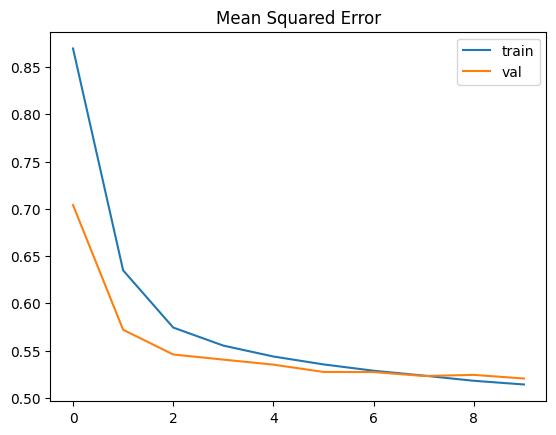

In [375]:
model = Sequential()
model.add(Dense(units=10, input_dim=x_train.shape[1], activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
history = model.fit(x_train, y_train, batch_size = int(ANN_random.best_params_['batch_size']),
        epochs = int(ANN_random.best_params_['epochs']), validation_split=0.2, verbose=0)

train_mse = model.evaluate(x_train, y_train, verbose=0)
test_mse = model.evaluate(x_test, y_test, verbose=0)
print(f'train_mse: {train_mse:.3f}, test_mse: {test_mse:.3f}')
y_train_pred = model.predict(x_train)

plt.title('Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [376]:
y_test_pred = model.predict(x_test)

y_train =  inverse_scale(y_train, std)
y_train_pred =  inverse_scale(y_train_pred, std)

y_test =  inverse_scale(y_test, std)
y_test_pred =  inverse_scale(y_test_pred, std)

73/73 [==============================] - 0s 528us/step


So sánh giá trị **actual** và **predict** trên tập test

In [378]:
compare = pd.DataFrame({'Actual': y_train, 'Predict': y_train_pred}).apply(lambda x: x/1e6)
compare.sample(5)

,Actual,Predict
2499,80.000,87.673
6857,95.650,95.913
5134,70.270,87.385
2550,154.550,171.728
6352,74.240,84.839


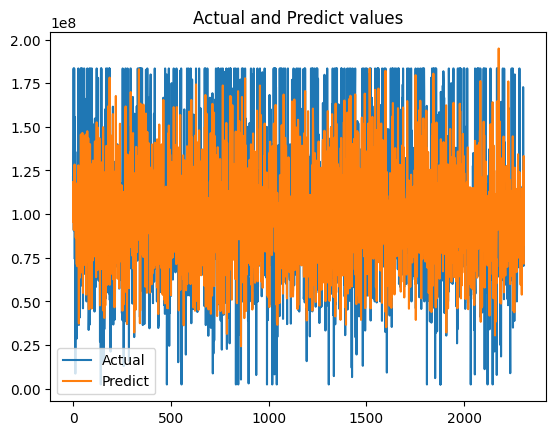

In [331]:
plt.plot(y_test)
plt.plot(y_test_pred)
plt.legend(['Actual', 'Predict'])
plt.title('Actual and Predict values')
plt.show()

In [332]:
print(f'Train set: [MAE: {mean_absolute_error(y_train, y_train_pred):.3f},\
      MAPE: {100-mean_absolute_percentage_error(y_train, y_train_pred):.3f}]')
print(f'Test set: [MAE: {mean_absolute_error(y_test, y_test_pred):.3f},\
      MAPE: {100-mean_absolute_percentage_error(y_test, y_test_pred):.3f}]')

Train set: [MAE: 20827500.593,      MAPE: 99.345]
Test set: [MAE: 21134672.188,      MAPE: 99.425]


#### **Fine-tune cho Random Forest Regression**

In [388]:
std = StandardScaler()
x_train, x_test, y_train, y_test = get_dataset(x_df, y_df, preprocessor, std)

In [61]:
rf = RandomForestRegressor()
# Không gian tham số
n_estimators = [200 , 400, 600, 800, 1000, 1200] # số lượng cây 
max_features = ['auto', 'sqrt'] # cách tính số lượng đặc trưng mỗi lần split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # độ sâu tối đa của cây
min_samples_split = [2, 6, 10] # số lượng mẫu tối thiểu trong một node
min_samples_leaf = [1, 3, 4] # số lượng mẫu tối thiểu trong một node lá
bootstrap = [True, False] # cách lấy mẫu (có hoàn lại hay không)

params = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = rf,param_distributions = params, 
                               scoring='neg_mean_absolute_error', return_train_score=True,
                               n_iter = 100, cv = 5, verbose=2, random_state=10)

rf_random.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=600; total time=   8.3s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=600; total time=   8.5s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=600; total time=   7.4s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=600; total time=   9.3s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=600; total time=   8.7s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=600; total time=   7.8s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=60

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      120],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200]},
                   random_state=10, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=2)

In [ ]:
result = pd.DataFrame(rf_random.cv_results_)
result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,8.417,0.627,0.125,0.008,600,6,4,sqrt,30,False,"{'n_estimators': 600, 'min_samples_split': 6, ...",-0.555,-0.531,-0.533,-0.552,-0.540,-0.542,0.010,56,-0.494,-0.498,-0.499,-0.493,-0.497,-0.496,0.002
1,7.852,0.470,0.126,0.001,600,6,3,sqrt,110,True,"{'n_estimators': 600, 'min_samples_split': 6, ...",-0.554,-0.532,-0.532,-0.551,-0.540,-0.542,0.009,54,-0.493,-0.498,-0.499,-0.493,-0.497,-0.496,0.002
2,18.376,1.537,0.256,0.010,1200,2,4,sqrt,120,False,"{'n_estimators': 1200, 'min_samples_split': 2,...",-0.553,-0.529,-0.531,-0.549,-0.539,-0.540,0.009,52,-0.487,-0.492,-0.493,-0.487,-0.490,-0.490,0.003
3,232.000,4.211,0.542,0.012,1200,2,1,auto,80,False,"{'n_estimators': 1200, 'min_samples_split': 2,...",-0.614,-0.641,-0.617,-0.620,-0.642,-0.627,0.012,100,-0.013,-0.014,-0.013,-0.013,-0.011,-0.013,0.001
4,13.068,0.721,0.179,0.001,800,10,3,sqrt,100,False,"{'n_estimators': 800, 'min_samples_split': 10,...",-0.545,-0.522,-0.523,-0.541,-0.530,-0.532,0.009,45,-0.466,-0.469,-0.471,-0.464,-0.466,-0.467,0.003


**Train lại với best params chọn được**

In [333]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': False}

In [389]:
rf = RandomForestRegressor(n_estimators=200, min_samples_split=6, min_samples_leaf=1, 
                           max_features='sqrt', max_depth=70, bootstrap=False)

rf.fit(x_train, y_train)
y_train_pred = rf.predict(x_train)

In [390]:
y_test_pred = model.predict(x_test)

y_train =  inverse_scale(y_train, std)
y_train_pred =  inverse_scale(y_train_pred, std)

y_test =  inverse_scale(y_test, std)
y_test_pred =  inverse_scale(y_test_pred, std)

73/73 [==============================] - 0s 611us/step


So sánh giá trị **actual** và **predict** trên tập test

In [391]:
compare = pd.DataFrame({'Actual': y_train, 'Predict': y_train_pred}).apply(lambda x: x/1e6)
compare.head(5)

,Actual,Predict
0,162.000,149.700
1,156.250,146.581
2,100.000,103.811
3,89.060,100.039
4,69.700,69.752


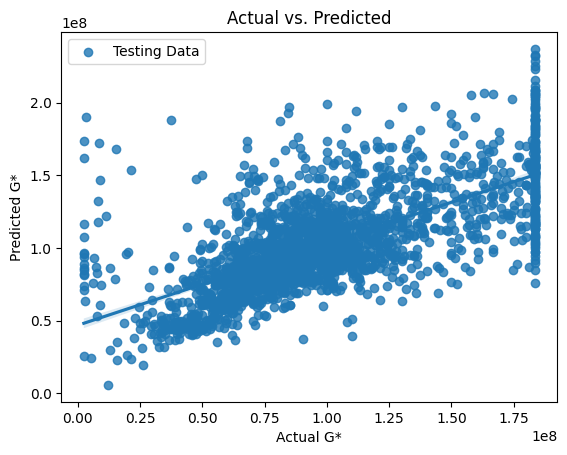

In [392]:
sns.regplot(x=y_test, y=y_test_pred, label="Testing Data")

plt.xlabel('Actual G*')
plt.ylabel('Predicted G*')
plt.title('Actual vs. Predicted')
plt.legend(loc="upper left")

In [393]:
print(f'Train set: [MAE: {mean_absolute_error(y_train, y_train_pred):.3f},\
      MAPE: {100-mean_absolute_percentage_error(y_train, y_train_pred):.3f}]')
print(f'Test set: [MAE: {mean_absolute_error(y_test, y_test_pred):.3f},\
      MAPE: {100-mean_absolute_percentage_error(y_test, y_test_pred):.3f}]')

Train set: [MAE: 9550043.165,      MAPE: 99.703]
Test set: [MAE: 21558844.276,      MAPE: 99.420]
